In [1]:
import os
os.chdir('../')

In [2]:
import pickle
import itertools

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
from xgboost.sklearn import XGBClassifier

In [3]:
data = pd.read_csv('data/cac40_v3.csv').drop('Unnamed: 0', axis=1)
data

,TICKER,annee,mois,jour,OP,UP,DO,CL,VO,RDMT_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
0,AC,2007,10,1,50.820,52.450,50.720,52.440,939518,0.045576,...,0,0,0,0,0,0,0,0,0,0
1,AC,2007,10,10,57.600,57.900,56.480,56.740,1167710,0.005640,...,0,0,0,0,0,0,0,0,0,0
2,AC,2007,10,11,56.570,57.900,56.570,57.060,910369,-0.005258,...,0,0,0,0,0,0,0,0,0,0
3,AC,2007,10,12,57.100,57.100,55.500,56.760,996349,-0.011628,...,0,0,0,0,0,0,0,0,0,0
4,AC,2007,10,15,56.760,57.290,55.770,56.100,573647,-0.003209,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106537,VIV,2017,9,4,20.065,20.235,20.030,20.100,2250835,0.002736,...,0,0,0,0,0,0,0,0,0,0
106538,VIV,2017,9,5,20.095,20.290,19.985,20.155,3095238,-0.001985,...,0,0,0,0,0,0,0,0,0,0
106539,VIV,2017,9,6,20.080,20.210,20.015,20.115,2181925,-0.006463,...,0,0,0,0,0,0,0,0,0,0
106540,VIV,2017,9,7,20.185,20.185,19.920,19.985,4038684,-0.002252,...,0,0,0,0,0,0,0,0,0,0


# Filtration des données
***

In [4]:
variables_num_dep = ["RDMT_J", "RDMT_S", "RDMT_M"]
variables_num_explic = ["OP", "UP", "DO", "CL", "VO"] + [f"{var}_{x}" for x in ["J", "S", "M"] for var in ["HISTO", "VOL", "UP", "DO"]]
numeric_variables = variables_num_dep + variables_num_explic
non_numeric_variables = data.columns[~data.columns.isin(numeric_variables)]
words = non_numeric_variables[4:]
descriptive_variables = non_numeric_variables[:4]

### Question 3)

Q : Montrer que, _quelque soit le ticker_, la liste des mots apparaissant sur 400 lignes et dont le rendement mensuel est en moyenne supérieur à 1% est telle que la table dans le sujet.  

In [5]:
# On veut l'effet du mot, indépendamment de ticker
freq_word_ret = {}
for word in words:
    if data[word].sum() > 400:
        mean_return = np.mean(data["RDMT_M"].loc[data[word] == 1])
        num_app = data[word].sum()
        if mean_return > 0.01:
            freq_word_ret[word] = (num_app, mean_return)

In [6]:
df = pd.DataFrame(freq_word_ret).transpose().rename(axis='columns', mapper={0:"Nombre d'apparitions", 1:"Rendement mensuel moyen"})
df["Nombre d'apparitions"] = df["Nombre d'apparitions"].astype('int64')
df.index.name = "Mot"
df

,Nombre d'apparitions,Rendement mensuel moyen
Mot,,
part,716,0.011925
plus,418,0.010119
pour,1966,0.013645
euros,446,0.010361
group,493,0.012940
passe,527,0.013763
titre,467,0.012178
groupe,467,0.014646
nouvel,494,0.011500


<b>Filtrer la base sur l'apparition de ces mots</b>

In [7]:
keepers = list(freq_word_ret.keys())
data["KEEP_ROW"] = data[keepers].sum(axis=1)
data = data.loc[~(data["KEEP_ROW"] == 0)].drop("KEEP_ROW", axis=1).reset_index(drop=True)

In [8]:
data.shape

(7129, 280)

### Question 4)

Q : Retrait des variables trop corrélées (positivement ou négativement).

In [9]:
CORRELATION_THRESHOLD = 0.75
correlation_matrix = data.loc[:,~data.columns.isin(["TICKER", "annee", "mois", "jour"])].corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
high_corr_vars = [col for col in upper_triangle.columns if any(upper_triangle[col] > CORRELATION_THRESHOLD)]

In [10]:
data.drop(high_corr_vars, axis=1, inplace=True)
data

,TICKER,annee,mois,jour,OP,VO,RDMT_J,RDMT_S,RDMT_M,HISTO_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
0,AC,2010,10,11,27.370,583747,0.020663,0.065797,0.123255,0.009700,...,0,0,0,0,0,0,0,0,0,0
1,AC,2010,10,28,29.220,752703,0.011500,0.053896,0.117920,-0.003251,...,0,0,0,0,0,0,0,0,0,0
2,AC,2010,10,6,26.950,1747197,-0.022407,0.042645,0.132093,0.030540,...,0,0,0,0,0,0,0,0,0,0
3,AC,2010,11,26,33.415,871648,-0.022133,-0.012626,0.001485,0.001339,...,0,0,0,0,0,0,0,0,0,0
4,AC,2010,11,3,29.745,880633,0.029165,0.040898,0.126383,0.004715,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,VIV,2017,9,20,21.075,2787945,-0.004282,-0.011180,-0.025690,-0.007085,...,0,0,0,0,0,0,0,0,0,0
7125,VIV,2017,9,25,20.710,2082640,-0.001445,0.037581,-0.002891,0.000482,...,0,0,0,0,0,0,0,0,0,0
7126,VIV,2017,9,26,20.765,1622952,0.002895,0.032569,-0.008203,-0.001445,...,0,0,0,0,0,0,0,0,0,0
7127,VIV,2017,9,29,21.060,6358735,0.005369,-0.012138,0.014006,0.029066,...,0,0,0,0,0,0,0,0,0,0


### Question 5)

Q : Choisir un algorithme parmi les suivants :
- XGBoost <b>X</b>
- GradientBoostingClassifier
- neural_network.MLPClassifier

**_Qu'est-ce que l'algorithme XGBoost?_**

_XGBoost_, de son nom _Extreme Gradient Boosting_ est un algorithme construit pour optimiser l'algorithme _Gradient Boosting_, qui est lui-même une variante du _Random Forest_. GB fait des prédicitions grâce à un ensemble d'arbres de décision qui "votent" pour la prédiction finale. Au différent de _Random Forest_, la construction même de l'ensemble d'arbres est faite de manière séquentielle de sorte à minimiser la fonction objectif par déscente de gradients.
_XGBoost_ cherche à optimiser l'implémentation de GB, notamment en parallélisant la construction des arbres et en optimisant l'utilisation de resources physiques disponibles.

### Question 6)

Q : Analyser les hyperparamètres et assurer un grid computing d'environ 100 n-uplets de paramètres. Une cross-validation de 4 folds est souhaitée.

D'après la [documentation officielle](https://xgboost.readthedocs.io/en/latest/parameter.html) de XGBoost il y a trois types de paramètres qui vont nous concerner dans cette étude.
> 1. **Paramètres Géneraux**: paramètres liés au choix de technique de boosting (avec modèle linéaire ou arbre de décisions)
> 2. **Paramètres de "booster"**: paramètres du booster choisi &rarr; concernent le _Bias-Variance tradeoff_
>> - learning_rate \[défault = 0.3] : contrôle le poids des features utilisées pour rendre l'algo plus conservateur (réduire possibilité d'overfit).
>> - min_child_weight \[defaut = 1] : définit le poids minimal d'un noeud enfant pour qu'il soit créé. Contrôle l'importance des relation à apprendre et donc l'overfitting.
>> - max_depth \[défaut = 6] : la profondeur maximale de chaque arbre créé. Contrôle contre l'overfit.
>> - gamma \[défaut = 0] : valeur minimale d'amélioration de l'objectif requise par l'algorithme pour continuer la création d'un noeud enfant dans un arbre. Contrôle l'overfit.
> 3. **Paramètres d'apprentissage**: paramètres liés à la tâche entreprise (i.e. qu'est-ce qu'on apprend ? comment ?)
>> - objective : fonction objectif d'apprentissage

avec : 
- _Bias_ : L'erreur moyenne de l'algo dans un unique jeu de données (fit)
- _Variance_ : La variation des erreurs de l'algo entre plusieurs jeux de données (généralisation)

voire aussi :
- [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## HYPER PARAMETER TUNING

In [11]:
from helper_functions import mean_encode

LABEL = "RDMT_M"

X = data.loc[:,~data.columns.isin(variables_num_dep)].copy()
y = data[LABEL].copy()
y_label = pd.DataFrame({'y':[1 if v > 0 else -1 for v in y]})
#y_label = y_label.y
y_label.name = "LABEL"

In [12]:
# define folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2, random_state=42)

In [13]:
# Fit the encoder on the training data to avoid leakage and encode tickers
ticker_encoder = mean_encode(X_train, y_train, "TICKER")
X_train.loc[:,"TICKER"] = X_train["TICKER"].apply(lambda x: ticker_encoder[x])
X_test.loc[:, "TICKER"] = X_test["TICKER"].apply(lambda x: ticker_encoder[x])

/Users/Cisco/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
X_train

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
6078,0.157025,2013,11,21,5.8890,5055329,-0.014240,0.062683,-0.087414,-0.121496,...,0,0,0,0,0,0,0,0,0,0
420,0.162500,2012,5,31,72.9752,1832219,0.014404,0.020952,-0.007522,0.373564,...,0,0,0,0,0,0,0,0,0,0
6245,0.169231,2014,12,11,61.0100,1605075,0.008680,-0.028702,-0.018799,-0.132576,...,0,0,0,0,0,0,0,0,0,0
553,0.162500,2017,6,12,99.8182,736467,-0.005920,-0.011770,-0.037054,-0.044647,...,0,0,0,0,0,0,0,0,1,0
1397,0.023810,2015,4,14,32.7000,2033524,-0.005498,0.030706,0.060068,-0.124818,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.055556,2016,2,17,33.1800,462741,0.057707,0.061252,-0.099198,0.530426,...,0,0,0,0,0,0,0,0,0,0
5191,0.078788,2014,7,2,69.2500,789727,0.007386,0.044131,0.009872,-0.427974,...,0,0,0,0,0,0,0,0,0,0
5226,0.078788,2015,4,27,97.5500,1283549,-0.000412,0.069429,0.168171,-0.346921,...,0,0,0,0,0,0,0,0,0,0
5390,0.363184,2013,3,25,36.0900,745321,-0.007704,-0.029589,0.041765,-0.028484,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# define parameter bounds and compute parameter grid
hyper_learning_rate = np.logspace(-4,0,5)
hyper_max_depth = np.linspace(3,10,5).astype('int64')
#hyper_min_child_weight = np.linspace(1,3,5).astype('int64') --> Doesn't seem to influence AUC
hyper_n_estimators = [50, 100, 200]
#hyper_gamma = np.linspace(0,2,5) Doesn't seem to influence AUC
hyper_subsample = [0.2, 0.4, 0.6, 0.8, 1]


hyper_parameter_list = [hyper_learning_rate, hyper_max_depth, 
                        hyper_n_estimators, hyper_subsample]
hyper_parameter_grid = list(itertools.product(*hyper_parameter_list))

In [16]:
len(hyper_parameter_grid)

375

In [17]:
'''from exploratory_notebooks.helper_functions import tune_XGB_hyper_params

results = tune_XGB_hyper_params(hyper_parameter_grid, X_train, y_train.y)'''

'from exploratory_notebooks.helper_functions import tune_XGB_hyper_params\n\nresults = tune_XGB_hyper_params(hyper_parameter_grid, X_train, y_train.y)'

In [18]:
# #############################
# GET RESULTS FROM CACHE
# ############################

In [19]:
'''tuning_results = open("results/hyper_param_tuning_results.pickle", "wb")
pickle.dump(results, tuning_results)
tuning_results.close()'''

with open("results/hyper_param_tuning_results.pickle", 'rb') as file:
    results = pickle.load(file)

In [20]:
from helper_functions import plot_tuning_results

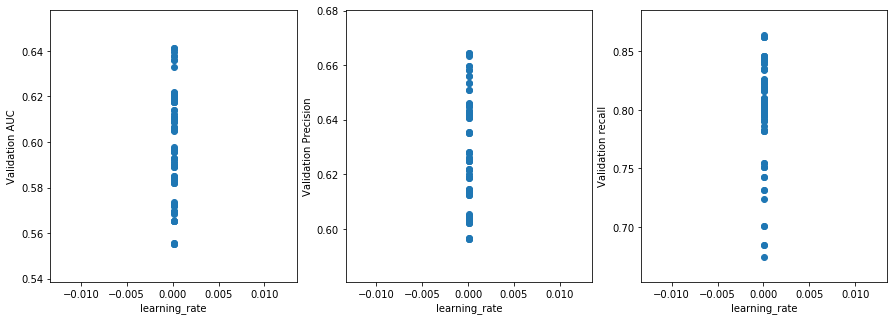

In [21]:
plot_tuning_results(results, 'learning_rate')

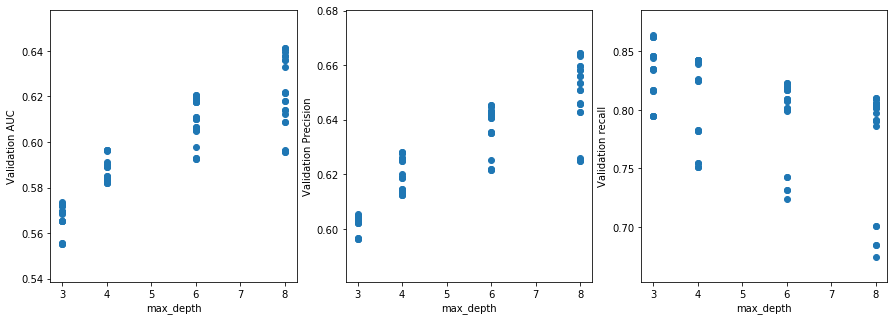

In [22]:
plot_tuning_results(results, 'max_depth')

In [23]:
plot_tuning_results(results, 'n_estimators')

KeyError: 'n_estimators'

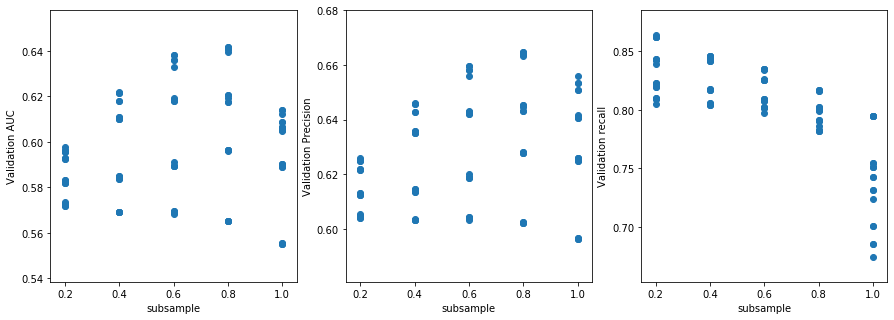

In [24]:
plot_tuning_results(results, 'subsample')

In [25]:
# Get "best" model as defined by L2 norm of computed metrics
#score_norms = [np.sqrt(pow(x['metriques']['auc'],2) + pow(x['metriques']['precision'],2) + pow(x['metriques']['recall'],2)) for x in results]
#max_score_norm = np.argmax(score_norms)
#max_score_norm_res = results[max_score_norm]
auc_scores = [x['metriques']['auc'] for x in results]
max_auc_ix = np.argmax(auc_scores)
max_auc_res = results[max_auc_ix]
max_auc_res

{'algorithm': 'XGBClassifier',
 'parametres': {'learning_rate': 0.0001,
  'max_depth': 8,
  'min_child_weight': 2,
  'subsample': 0.8},
 'metriques': {'auc': 0.6415, 'precision': 0.6646, 'recall': 0.7902}}

In [26]:
learning_rate = max_auc_res['parametres']['learning_rate']
max_depth = max_auc_res['parametres']['max_depth']
min_child_weight = max_auc_res['parametres']['min_child_weight']
subsample = max_auc_res['parametres']['subsample']
xgb = XGBClassifier(learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_child_weight=min_child_weight,
                    subsample=subsample)

In [27]:
model = xgb.fit(X_train, y_train.y)
y_test_pred = model.predict(X_test)

In [28]:
roc_auc_score(y_test, y_test_pred)

0.6359659534063549

## FEATURE IMPORTANCE

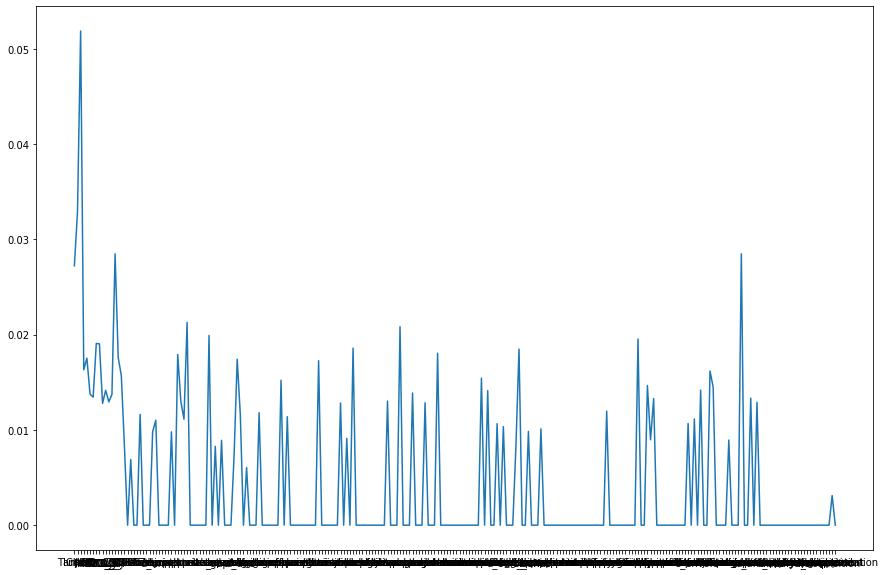

In [29]:
features = X_train.columns
importances = model.feature_importances_
plt.plot(features, importances)
plt.gcf().set_size_inches(15,10);

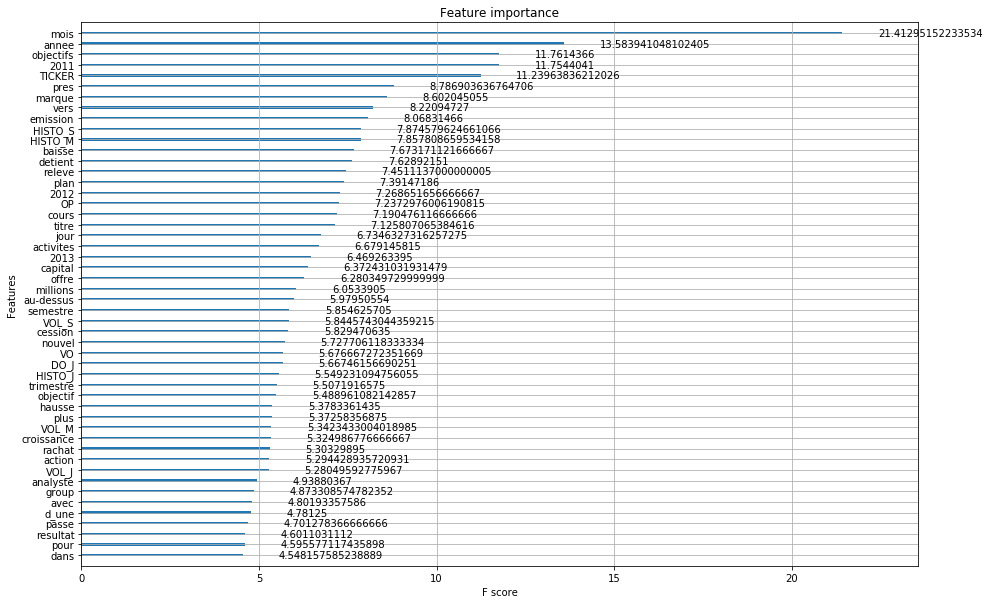

In [30]:
from xgboost import plot_importance
plot_importance(model, max_num_features=50, importance_type="gain")
plt.gcf().set_size_inches(15,10);

In [31]:
features = X_train.columns[~(importances == 0)]
X_1 = X[features]
X_1

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,remporte,resultat,semestre,activites,au-dessus,dividende,objectifs,trimestre,croissance,participation
0,AC,2010,10,11,27.370,583747,0.009700,0.059332,0.067944,-0.356155,...,0,0,0,0,0,0,0,0,0,0
1,AC,2010,10,28,29.220,752703,-0.003251,0.013923,0.106343,-0.264331,...,0,0,0,0,0,0,0,0,0,0
2,AC,2010,10,6,26.950,1747197,0.030540,0.041596,0.087230,0.924626,...,0,0,0,0,0,0,0,0,0,0
3,AC,2010,11,26,33.415,871648,0.001339,0.051875,0.151754,-0.202305,...,0,0,0,0,0,0,0,0,0,0
4,AC,2010,11,3,29.745,880633,0.004715,0.020701,0.145545,1.098479,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,VIV,2017,9,20,21.075,2787945,-0.007085,-0.010125,0.122863,-0.126979,...,0,0,0,0,0,0,0,0,0,0
7125,VIV,2017,9,25,20.710,2082640,0.000482,-0.006700,0.095540,-0.489023,...,0,0,0,0,0,0,0,0,0,0
7126,VIV,2017,9,26,20.765,1622952,-0.001445,-0.021020,0.069401,-0.220724,...,0,0,0,0,0,0,0,0,0,0
7127,VIV,2017,9,29,21.060,6358735,0.029066,0.032538,0.105834,1.942386,...,0,0,0,0,0,0,0,0,0,0


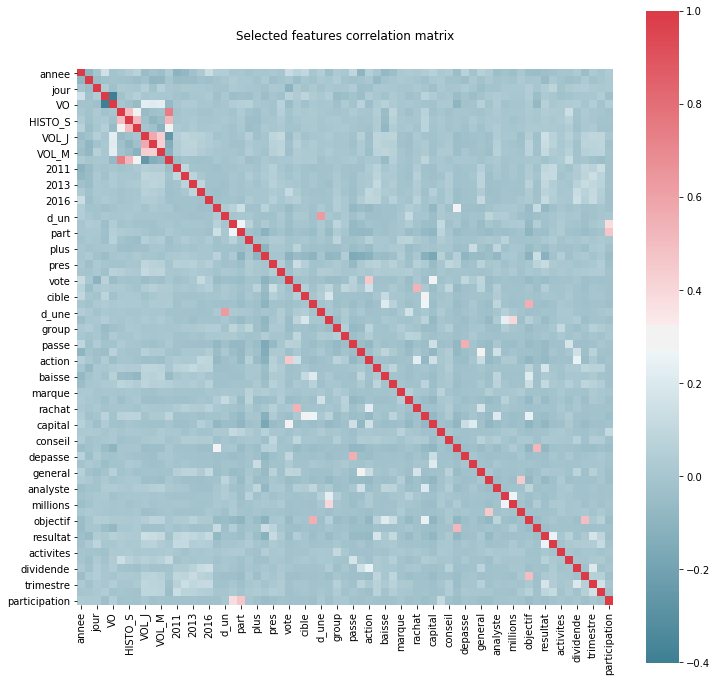

In [32]:
from exploratory_notebooks.helper_functions import plot_correlation_matrix

plot_correlation_matrix(X_1.corr(), "Selected features correlation matrix", 'seaborn')

### Question 7)

Q : Définir la variable à expliquer comme une variable binaire sur les niveaux de rendements de la base filtrée et ce tout ticker confondu. Utiliser le package plotly pour dessiner un graphe de votre choix avec la variable à expliquer en ordonnée.

In [33]:
dataset = X.merge(y_label, right_index=True, left_index=True)
dataset.head()

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation,y
0,AC,2010,10,11,27.370,583747,0.009700,0.059332,0.067944,-0.356155,...,0,0,0,0,0,0,0,0,0,1
1,AC,2010,10,28,29.220,752703,-0.003251,0.013923,0.106343,-0.264331,...,0,0,0,0,0,0,0,0,0,1
2,AC,2010,10,6,26.950,1747197,0.030540,0.041596,0.087230,0.924626,...,0,0,0,0,0,0,0,0,0,1
3,AC,2010,11,26,33.415,871648,0.001339,0.051875,0.151754,-0.202305,...,0,0,0,0,0,0,0,0,0,1
4,AC,2010,11,3,29.745,880633,0.004715,0.020701,0.145545,1.098479,...,0,0,0,0,0,0,0,0,0,1


In [34]:
import ipywidgets as widgets
import plotly.graph_objects as go

In [45]:
choices = {x:x for x in features if dataset[x].value_counts().shape[0] == 2}
choices.update({"ALL":"ALL"})

def on_change(change):
    if not change == None:
        return change
    else: 
        return "ALL"

res = widgets.interactive(on_change, change=choices)
display(res)

interactive(children=(Dropdown(description='change', options={'2011': '2011', '2012': '2012', '2013': '2013', …

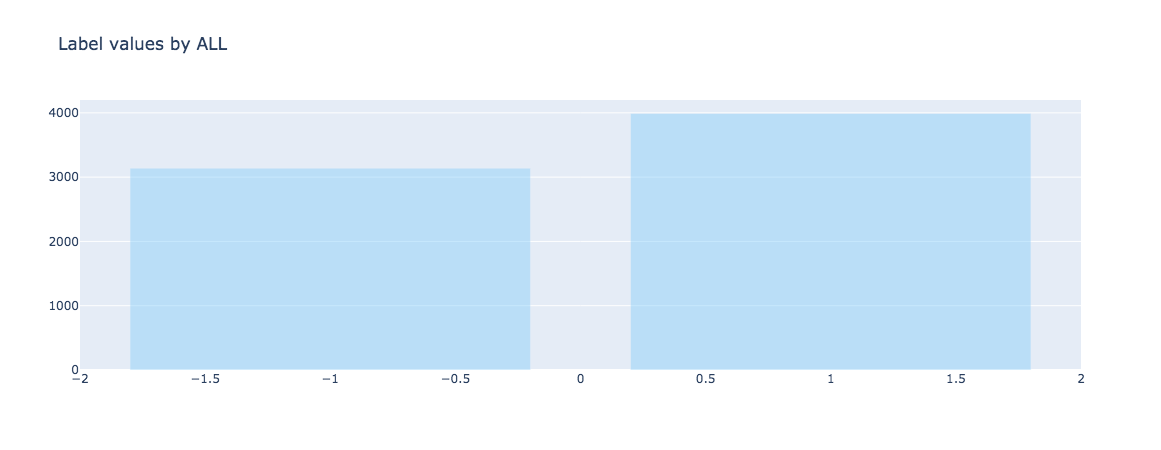

In [188]:
if res.result == "ALL":
    plot_data = dataset
else:
    plot_data = dataset.loc[dataset[f"{res.result}"]==1]
    
x = [-1, 1]
y = [abs(plot_data.query('y==-1')['y'].sum()), 
    plot_data.query('y==1')['y'].sum()]

fig = go.FigureWidget(
            data=[go.Bar(x=x, y=y,
                         marker_color='lightskyblue',
                         opacity=0.45)], 
            layout_title_text=f"Label values by {res.result}")

fig.show()

### Question 8)

Q : Obtenir le meilleur modèle suivant 2 des 3 métriques suivantes : auc, précision, recall ainsi que le top 4 de l'importance des variables

### DATA PREPROCESSING

In [49]:
from exploratory_notebooks.helper_functions import handle_outliers
from exploratory_notebooks.helper_functions import mean_encode

In [50]:
# remove outliers found related to volume
preprocdata = handle_outliers(data, ["VO"] + [f"VOL_{x}" for x in ["J", "S", "M"]], 'remove')
preprocdata.reset_index(drop=True, inplace=True)
preprocdata.shape

(6958, 247)

In [51]:
LABEL = "RDMT_M"

X = preprocdata.loc[:,~data.columns.isin(variables_num_dep)].copy()
y = preprocdata[LABEL].copy()
y_label = pd.DataFrame({'y':[1 if v > 0 else -1 for v in y]})
#y_label = y_label.y
y_label.name = "LABEL"

In [52]:
# define folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2, random_state=42)

In [53]:
# Fit the encoder on the training data to avoid leakage and encode tickers
ticker_encoder = mean_encode(X_train, y_train, "TICKER")
X_train.loc[:,"TICKER"] = X_train["TICKER"].apply(lambda x: ticker_encoder[x])
X_test.loc[:, "TICKER"] = X_test["TICKER"].apply(lambda x: ticker_encoder[x])

/Users/Cisco/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
X_train

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,strategique,transaction,actionnaires,coentreprise,construction,collaboration,developpement,l_acquisition,participation,recommandation
44,0.000000,2017,8,11,39.285,997020,-0.011139,-0.037813,-0.060832,0.399955,...,0,0,0,0,0,0,0,0,0,0
3320,0.016393,2016,6,6,35.450,2581913,-0.006880,-0.052131,0.084816,-0.450697,...,0,0,0,0,0,0,0,0,0,0
4020,0.102041,2014,3,21,89.970,866695,-0.002563,0.026258,0.037320,0.335497,...,0,0,0,0,0,0,0,0,0,0
964,0.025210,2013,6,17,43.400,2861413,0.010860,-0.003417,-0.045802,-0.062397,...,0,0,0,0,0,0,0,0,0,0
1553,0.260274,2009,3,13,8.220,17358450,-0.023858,0.228090,-0.371581,0.183835,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.308824,2017,10,4,61.610,429439,0.001790,0.020896,0.051768,1.108804,...,0,0,0,0,0,0,0,0,0,0
5191,0.326316,2012,9,10,27.970,585159,-0.009626,-0.012618,-0.027822,-0.236918,...,0,0,0,0,0,0,0,0,0,0
5226,0.326316,2013,5,22,40.805,751714,-0.005621,0.026359,0.163735,-0.198348,...,0,0,0,0,0,0,0,0,0,0
5390,0.326316,2017,4,25,75.950,1029410,-0.000923,0.041798,0.095100,-0.529982,...,0,0,0,0,0,0,0,0,0,0


In [58]:
learning_rate = max_auc_res['parametres']['learning_rate']
max_depth = max_auc_res['parametres']['max_depth']
min_child_weight = max_auc_res['parametres']['min_child_weight']
subsample = max_auc_res['parametres']['subsample']
xgb = XGBClassifier(learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_child_weight=min_child_weight,
                    subsample=subsample,
                    n_estimators=100)

In [59]:
model = xgb.fit(X_train, y_train.y)
y_test_pred = model.predict(X_test)

In [60]:
roc_auc_score(y_test, y_test_pred)

0.6210982117877705

#### Mean encode all non-binary categorical variables i.e. dates + tickers

In [61]:
year_encoder = mean_encode(X_train, y_train, "annee")
month_encoder = mean_encode(X_train, y_train, "mois")
day_encoder = mean_encode(X_train, y_train, "jour")

X_train.loc[:,"annee"] = X_train.loc[:,"annee"].apply(lambda x: year_encoder[x])
X_train.loc[:,"mois"] = X_train.loc[:,"mois"].apply(lambda x: month_encoder[x])
X_train.loc[:,"jour"] = X_train.loc[:,"jour"].apply(lambda x: day_encoder[x])

X_test.loc[:,"annee"] = X_test.loc[:,"annee"].apply(lambda x: year_encoder[x])
X_test.loc[:,"mois"] = X_test.loc[:,"mois"].apply(lambda x: month_encoder[x])
X_test.loc[:,"jour"] = X_test.loc[:,"jour"].apply(lambda x: day_encoder[x])

/Users/Cisco/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
model = xgb.fit(X_train, y_train.y)
y_test_pred = model.predict(X_test)

In [63]:
auc = roc_auc_score(y_test, y_test_pred)
auc

0.6213264449684576

#### **NO** : Standard scale all non-categorical variables

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
num_vars = ["OP","VO"] + [f"{name}_{horizon}" for horizon in ["J", "S", "M"] for name in ["HISTO", "VOL"]] + ["DO_J"]

scaler = StandardScaler()
scaler.fit(X_train.loc[:,num_vars])

X_train.loc[:, num_vars] = scaler.transform(X_train.loc[:, num_vars])

In [ ]:
X_train

In [ ]:
model = xgb.fit(X_train, y_train.y)
y_pred_test = model.predict(X_test)

In [ ]:
roc_auc_score(y_test.y, y_pred_test)

&rarr; **No Standard Scaling should be done**

### Find all class imbalances in words

In [64]:
words = list(X_train.columns[13:])

In [65]:
counts = {}
for word in words:
    counts.update({word:preprocdata.loc[:, word].value_counts()})

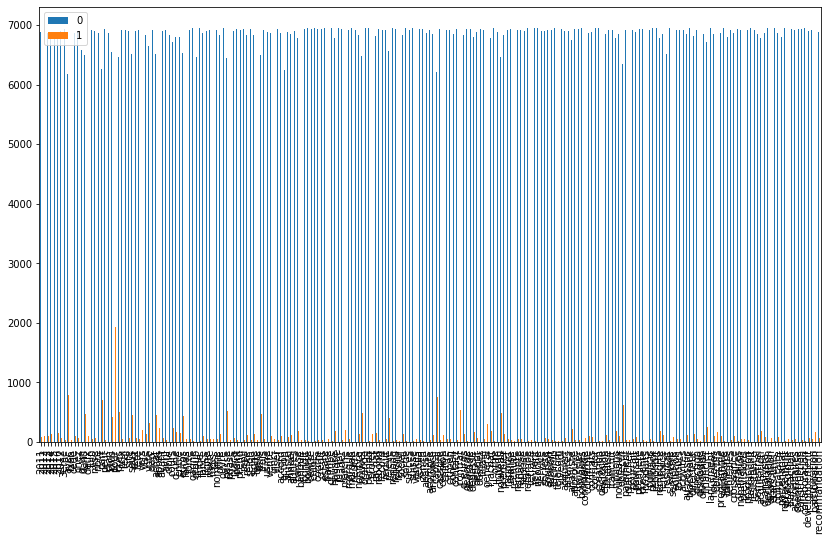

In [66]:
pd.DataFrame(index=counts.keys(), data=counts.values()).plot.bar(figsize=(14,8))

### IDEA: PCA word variables &rarr; Lost 2% AUC. **NO**

In [124]:
from sklearn.decomposition import PCA
pca_X_train, pca_y_train = X_train.copy(), y_train.copy()
pca_X_test, pca_y_test = X_test.copy(), y_test.copy()

In [125]:
word_data = pca_X_train.loc[:, words]
word_data.shape

(5566, 231)

In [126]:
pca = PCA()
pca_X_train.loc[:,words] = pca.fit_transform(word_data)

In [127]:
model = xgb.fit(pca_X_train, pca_y_train.y)
y_pred_test = model.predict(pca_X_test)
roc_auc_score(pca_y_test, y_pred_test)

0.6092753123218572

In [128]:
last_kept_word = words[np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]]
pca_X_train = pca_X_train.loc[:,:last_kept_word]
pca_X_test = pca_X_test.loc[:,:last_kept_word]

In [129]:
model = xgb.fit(pca_X_train, pca_y_train.y)
y_pred_test = model.predict(pca_X_test)
roc_auc_score(pca_y_test, y_pred_test)

0.6132678153351663

### IDEA: Clustering on word variables

##### Hierarchical clustering

In [164]:
from sklearn.cluster import FeatureAgglomeration

cluster_X_train, cluster_y_train = X_train.copy(), y_train.copy()
cluster_X_test, cluster_y_test = X_test.copy(), y_test.copy()

In [165]:
ward = FeatureAgglomeration(n_clusters=20)
ward.fit(cluster_X_train.loc[:, words])

clustered_words = ward.transform(cluster_X_train.loc[:, words])
clustered_test_words = ward.transform(cluster_X_test.loc[:, words])

In [166]:
cluster_X_train = cluster_X_train.drop(words, axis='columns')
cluster_X_test = cluster_X_test.drop(words, axis='columns')
for i in range(clustered_words.shape[1]):
    cluster_X_train[f"Word cluster {i}"] = clustered_words[:,i]
    cluster_X_test[f"Word cluster {i}"] = clustered_test_words[:, i]

In [167]:
model = xgb.fit(cluster_X_train, cluster_y_train.y)
y_pred_test = model.predict(cluster_X_test)
roc_auc_score(cluster_y_test, y_pred_test)

0.6200948272053952

**Non material loss in AUC**

##### KMeans

In [173]:
from sklearn.cluster import KMeans

cluster_X_train, cluster_y_train = X_train.copy(), y_train.copy()
cluster_X_test, cluster_y_test = X_test.copy(), y_test.copy()

In [175]:
km = KMeans(n_clusters=20)
km.fit(cluster_X_train.loc[:, words])

clustered_words = km.transform(cluster_X_train.loc[:, words])
clustered_test_words = km.transform(cluster_X_test.loc[:, words])

In [176]:
cluster_X_train = cluster_X_train.drop(words, axis='columns')
cluster_X_test = cluster_X_test.drop(words, axis='columns')
for i in range(clustered_words.shape[1]):
    cluster_X_train[f"Word cluster {i}"] = clustered_words[:,i]
    cluster_X_test[f"Word cluster {i}"] = clustered_test_words[:, i]

In [177]:
model = xgb.fit(cluster_X_train, cluster_y_train.y)
y_pred_test = model.predict(cluster_X_test)
roc_auc_score(cluster_y_test, y_pred_test)

0.621094004724532

In [178]:
cluster_X_train.head()

,TICKER,annee,mois,jour,OP,VO,HISTO_J,HISTO_S,HISTO_M,VOL_J,...,Word cluster 10,Word cluster 11,Word cluster 12,Word cluster 13,Word cluster 14,Word cluster 15,Word cluster 16,Word cluster 17,Word cluster 18,Word cluster 19
44,0.000000,0.170483,0.127726,0.150000,39.285,997020,-0.011139,-0.037813,-0.060832,0.399955,...,2.454547,1.824962,2.199478,1.857060,1.773843,0.989332,2.49873,1.826328,2.305463,2.095812
3320,0.016393,0.108830,-0.091255,0.079208,35.450,2581913,-0.006880,-0.052131,0.084816,-0.450697,...,2.248621,2.068156,2.407249,1.022890,2.036300,2.073728,2.67393,2.082180,2.460874,2.301229
4020,0.102041,0.026063,0.253333,0.098901,89.970,866695,-0.002563,0.026258,0.037320,0.335497,...,2.454547,1.807872,2.170054,1.853871,1.020420,1.816685,2.47990,1.800879,2.297416,2.045178
964,0.025210,0.245470,-0.091255,0.303371,43.400,2861413,0.010860,-0.003417,-0.045802,-0.062397,...,2.653403,2.068156,2.386388,2.103569,1.276049,2.075618,2.67393,2.061761,2.483346,2.287168
1553,0.260274,0.301435,0.253333,0.118280,8.220,17358450,-0.023858,0.228090,-0.371581,0.183835,...,2.454547,1.820095,2.196228,1.852274,1.778402,1.603413,2.47990,1.815768,2.032233,2.095812


##### **Non material loss in AUC**

### IDEA: Rebalance label. There are currently ~1000 less negative observations than positive &rarr; **1% GAIN IN AUC**

**SMOTE**

In [199]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [192]:
oversample = SMOTE()

over_X_train, over_y_train = X_train.copy(), y_train.copy()
over_X_test, over_y_test = X_test.copy(), y_test.copy()

over_X_train, over_y_train = oversample.fit_resample(over_X_train, over_y_train.y)

In [198]:
model = xgb.fit(over_X_train, over_y_train)
y_pred_test = model.predict(over_X_test)
roc_auc_score(over_y_test.y, y_pred_test)

0.6328842994503472

**SMOTE + Undersampling of majority class**

In [217]:
over = SMOTE()
under = RandomUnderSampler()

steps = [('over',over), ('under', under)]
pipeline = Pipeline(steps=steps)

X_res_train, y_res_train = pipeline.fit_resample(over_X_train, 
                                                 over_y_train)

In [218]:
model = xgb.fit(over_X_train, over_y_train)
y_pred_test = model.predict(over_X_test)
roc_auc_score(over_y_test.y, y_pred_test)

0.6328842994503472

In [215]:
y_res_train.value_counts()

-1    3104
 1    3104
Name: y, dtype: int64